## Internetsuche mithilfe eines Agenten

In diesem Notebook werden wir einen Agenten eine Internetrecherche durchführen und uns eine Frage beantworten lassen.

**Voraussetzung**

Bei [Tavily](https://app.tavily.com/) anmelden und einen API Key generieren. Dieser muss anschließend in unsere `.env` eingefügt oder im Code hinterlegt werden.



### 1. Imports
In dieser Zelle importieren wir die notwendigen Klassen und Funktionen.
- `START` und `END` sind spezielle Marker von **LangGraph**, die den Anfang und das Ende eines Graphen repräsentieren.
- `StateGraph` ist eine zentrale Klasse von LangGraph, die unseren Workflow konfiguriert.
- `TypedDict` hilft uns dabei, den "State" (Zustand) typisiert anzulegen, was den Code besser verständlich macht und potenzielle Fehler frühzeitig erkennen lässt.
- `IPython.display` (mit `Image`, `display`) wird genutzt, um innerhalb von Jupyter Notebooks Grafiken anzuzeigen, z.B. unser Graph-Diagramm.
- `TavilyClient` ist unser Client, um die **Tavily-API** ansprechen zu können.


In [2]:
import os
from dotenv import load_dotenv
from langgraph.graph import START, StateGraph, END
from typing_extensions import TypedDict
from IPython.display import Image, display
from tavily import TavilyClient

### 2. Laden der Umgebungsvariablen
Hier wird der API Key von Tavily aus der `.env` eingelesen.

In [3]:
load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY", "")

### 3. State definieren
Wir definieren einen `MyState` (auf Basis von `TypedDict`), der folgende Felder enthält:
- `topic`: Das Thema oder die Suchanfrage, das der Benutzer vorgibt.
- `result`: Eine Liste, in der die Suchergebnisse von Tavily gespeichert werden.


In [4]:
# State
class MyState(TypedDict):
    topic: str
    result: list

### 4. Erstellen der Node (Funktion `internet_search`)

- Diese Funktion nimmt den State entgegen (`topic` wird genutzt, um eine Anfrage an Tavily zu stellen).
- Dann wird ein `TavilyClient` mit dem geladenen API-Key erstellt.
- Anschließend rufen wir `qna_search(...)` auf und speichern das Ergebnis im State-Schlüssel `"result"`.


In [5]:
# Node
def internet_search(state: MyState):
    
    # Client erstellen
    tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

    # Über den Client eine Suchanfrage stellen
    context = tavily_client.qna_search(query=state["topic"])

    return {"result": context}

### 5. Aufbau und Kompilieren des Graphen

- Wir erzeugen eine `StateGraph(MyState)`-Instanz.
- Fügen eine Node namens `"Search Agent"` hinzu, die auf unsere Funktion `internet_search` verweist.
- Definieren die Kanten: `START -> "Search Agent" -> END`.
- Kompilieren (`.compile()`) den Graph, damit er ausführbar wird.

In [6]:
# StateGraph initialisieren
graph = StateGraph(MyState)

# Agent (Node) hinzufügen
graph.add_node("Search Agent", internet_search)

# Ablauf im Graph definieren
graph.add_edge(START, "Search Agent")
graph.add_edge("Search Agent", END)

# Graph erstellen
graph = graph.compile()

### 5. Graph visualisieren

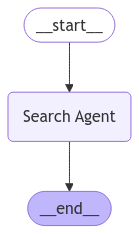

In [7]:
# Graph anzeigen lassen
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### 6. Graph aufrufen
Wir rufen `graph.invoke({...}, debug=True)` auf und übergeben ein Dictionary, das unserem State-Schema entspricht – hier also `{"topic": "Are all Flowers yellow?"}`. 

- Der Graph startet bei `START`.
- Wechselt zur Node **Search Agent**.
- Führt die Suche aus und setzt das Ergebnis in `result`.
- Anschließend endet der Graph (`END`).

Das Ergebnis liegt im zurückgegebenen `result_state`.

In [8]:
# Graph aufrufen
result_state = graph.invoke({"topic": "Are all Flowers yellow?",}, debug=True)


[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'topic': 'Are all Flowers yellow?'}
[0:writes] Finished step 0 with writes to 1 channel:
- topic -> 'Are all Flowers yellow?'
[0:checkpoint] State at the end of step 0:
{'topic': 'Are all Flowers yellow?'}
[1:tasks] Starting 1 task for step 1:
- Search Agent -> {'topic': 'Are all Flowers yellow?'}
[1:writes] Finished step 1 with writes to 1 channel:
- result -> ('Not all flowers are yellow. While many flowers do exhibit yellow '
 'pigmentation due to various plant pigments, flowers come in a wide range of '
 'colors including red, blue, pink, white, and purple. The color of a flower '
 'is determined by the pigments present in the petals, and yellow is just one '
 'of many possible colors.')
[1:checkpoint] State at the end of step 1:
{'result': 'Not all flowers are yellow. While many flowers do exhibit yellow '
           'pigmentation due to various plant pigments, flowers come in a w

### 7. Ausgabe des Ergebnisses

In [9]:
print(f"Die Internetrecherche hat folgendes ergeben: {result_state["result"]}")

Die Internetrecherche hat folgendes ergeben: Not all flowers are yellow. While many flowers do exhibit yellow pigmentation due to various plant pigments, flowers come in a wide range of colors including red, blue, pink, white, and purple. The color of a flower is determined by the pigments present in the petals, and yellow is just one of many possible colors.


## Zusammenfassung
In diesem Notebook hast du gesehen, wie man: 
1. **LangGraph** verwendet, um einen einfachen Workflow mit Start und Ende zu erstellen.
2. Eine Node anlegt, die mithilfe der **Tavily-API** eine Suche durchführt.
3. Die Ergebnisse in einem typisierten State ablegt und nachher ausliest.

Weitere Ideen:
- Übersetze das Ergebnis auf deutsch, indem du noch ein "Übersetzer-Agenten" definierst. 
- Ergänze einen **Summarizer-Agent**, der die Suchergebnisse zusammenfasst.
- Kombiniere den Graph mit anderen LLMs (z. B. via StackIT), um eine Chat-Interaktion zu ermöglichen.
- Baue einen "Multi-Step"-Graphen, in dem die Suchergebnisse an einen Fact-Check-Agenten gehen oder automatisch im nächsten Schritt verarbeitet werden.

Viel Spaß beim Ausprobieren!